In [1]:
from fredapi import Fred
import pandas as pd

fred = Fred(api_key="d56526f64808d2daa6f74c5775edfb03")

tickers = {
    "1M": "GS1M", "3M": "GS3M", "6M": "GS6M", "1Y": "GS1", "2Y": "GS2", "3Y": "GS3",
    "5Y": "GS5", "7Y": "GS7", "10Y": "GS10", "20Y": "GS20", "30Y": "GS30"}

df = pd.DataFrame()
for label, code in tickers.items():
    df[label] = fred.get_series(code)

df = df.dropna().sort_index()
df.head()

,1M,3M,6M,1Y,2Y,3Y,5Y,7Y,10Y,20Y,30Y
2001-07-01,3.67,3.59,3.56,3.62,4.04,4.31,4.76,5.06,5.24,5.75,5.61
2001-08-01,3.53,3.44,3.39,3.47,3.76,4.04,4.57,4.84,4.97,5.58,5.48
2001-09-01,2.68,2.69,2.71,2.82,3.12,3.45,4.12,4.51,4.73,5.53,5.48
2001-10-01,2.27,2.20,2.17,2.33,2.73,3.14,3.91,4.31,4.57,5.34,5.32
2001-11-01,1.99,1.91,1.92,2.18,2.78,3.22,3.97,4.42,4.65,5.33,5.12


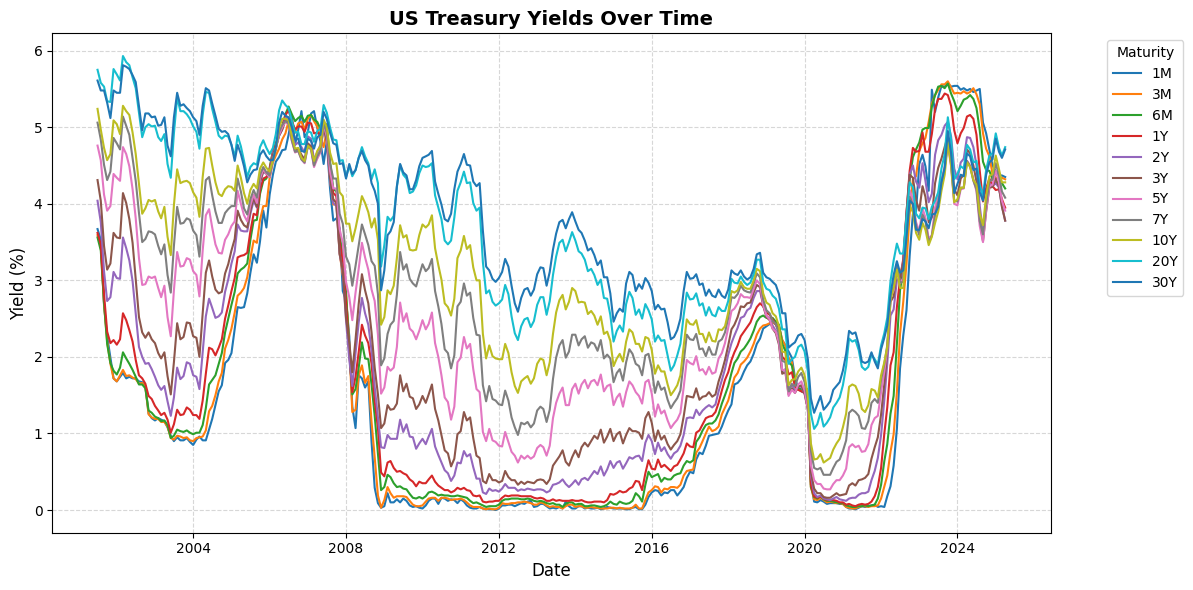

In [39]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

for column in df.columns:
    plt.plot(df.index, df[column], label=column)

plt.title("US Treasury Yields Over Time", fontsize=14, fontweight='bold')
plt.xlabel("Date", fontsize=12)
plt.ylabel("Yield (%)", fontsize=12)
plt.legend(title="Maturity", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

### US Treasury Yields follow similar trends overtime, so their time series data is intercorrelated

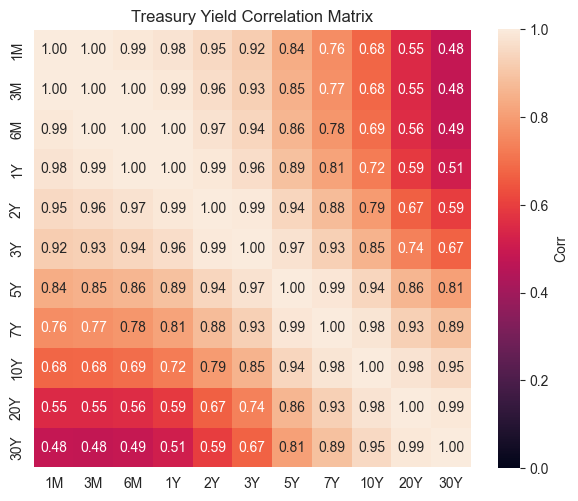

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns  # purely for heat-map aesthetics

# Compute correlations on the (level) yields
corr = df.corr()

plt.figure(figsize=(6,5))
sns.heatmap(corr, annot=True, fmt=".2f",
            vmin=0.0, vmax=1.0, square=True,
            cbar_kws={"label": "Corr"})
plt.title("Treasury Yield Correlation Matrix")
plt.tight_layout()
plt.savefig("yield_corr_heatmap.png", dpi=300)
plt.show()

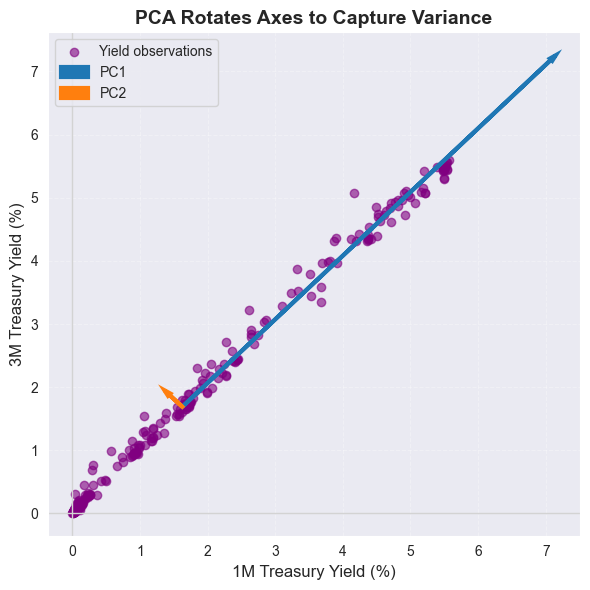

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Use actual data: 1M vs 3M Treasury yields
x = df['1M']
y = df['3M']
X = np.vstack([x, y]).T

# Fit PCA
pca = PCA()
pca.fit(X)
components = pca.components_
mean = pca.mean_
explained_var = pca.explained_variance_

plt.figure(figsize=(6,6))
plt.scatter(X[:, 0], X[:, 1], alpha=0.6, label='Yield observations', color='purple')

# Draw the principal components
for i, (length, vector) in enumerate(zip(explained_var, components)):
    v = vector * 3 * np.sqrt(length)
    plt.arrow(mean[0], mean[1], v[0], v[1], 
              head_width=0.05, head_length=0.1, 
              linewidth=3, color=f"C{i}", label=f"PC{i+1}")

# Reference lines & aesthetics
plt.axhline(0, color='lightgrey', lw=1)
plt.axvline(0, color='lightgrey', lw=1)
plt.xlabel("1M Treasury Yield (%)", fontsize=12)
plt.ylabel("3M Treasury Yield (%)", fontsize=12)
plt.title("PCA Rotates Axes to Capture Variance", fontsize=14, fontweight='bold')
plt.legend(loc='upper left')
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.savefig("pca_yield_visual.png", dpi=300)
plt.show()

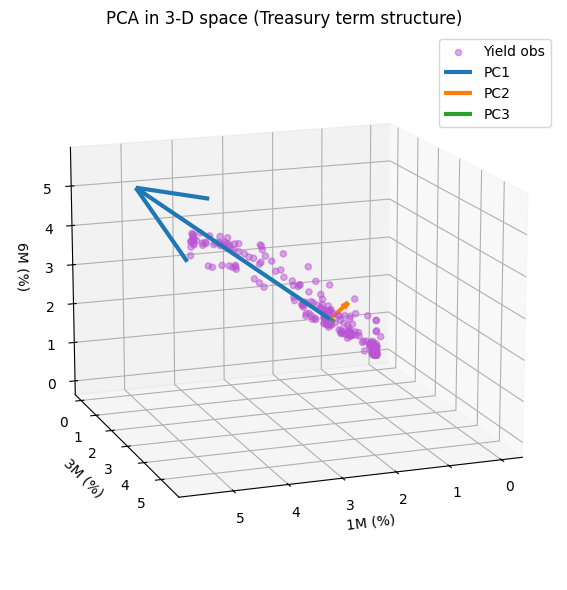

In [60]:
# 3-D PCA on 1M, 3M, 6M yields
cols_3d = ['1M', '3M', '6M']
X3 = df[cols_3d].values

pca3 = PCA(n_components=3).fit(X3)
mean3 = pca3.mean_
comps3 = pca3.components_
expvar3 = pca3.explained_variance_

# 3-D scatter of the raw obs
fig = plt.figure(figsize=(7, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X3[:, 0], X3[:, 1], X3[:, 2],
           alpha=0.5, s=20, label='Yield obs', color='mediumorchid')

# draw the 3 principal axes
for i, (vec, var) in enumerate(zip(comps3, expvar3), 1):
    v = vec * 3 * np.sqrt(var)
    ax.quiver(*mean3, *v,
              linewidth=3, color=f"C{i-1}", label=f"PC{i}")

# Labels + pretties
ax.set_xlabel(f"{cols_3d[0]} (%)")
ax.set_ylabel(f"{cols_3d[1]} (%)")
ax.set_zlabel(f"{cols_3d[2]} (%)")
ax.set_title("PCA in 3-D space (Treasury term structure)")
ax.legend()
plt.tight_layout()
ax.view_init(elev=15, azim=70)

plt.show()


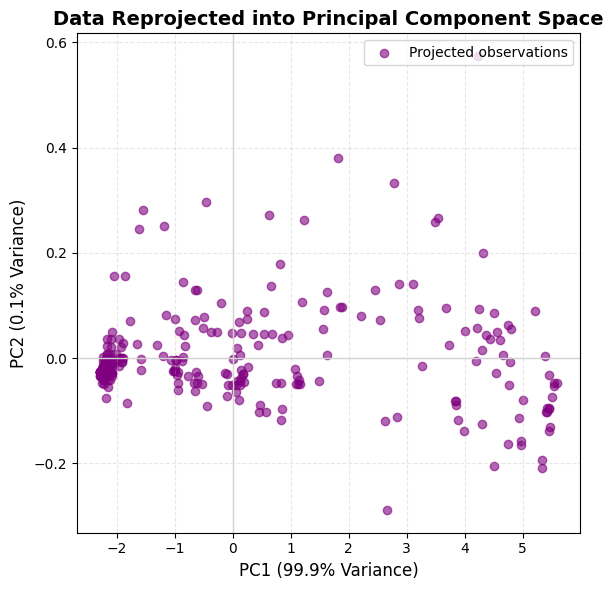

In [34]:
# prepare data (already standardized in this example)
x = df['1M']
y = df['3M']
X = np.vstack([x, y]).T

# fit PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)
explained_var = pca.explained_variance_ratio_ * 100  # convert to percentage

# plot in PC space
plt.figure(figsize=(6,6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.6, color='purple', label='Projected observations')

# reference lines
plt.axhline(0, color='lightgrey', lw=1)
plt.axvline(0, color='lightgrey', lw=1)

# labels and title
plt.xlabel(f"PC1 ({explained_var[0]:.1f}% Variance)", fontsize=12)
plt.ylabel(f"PC2 ({explained_var[1]:.1f}% Variance)", fontsize=12)
plt.title("Data Reprojected into Principal Component Space", fontsize=14, fontweight='bold')
plt.legend(loc='upper right')
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.savefig("pca_projection_plot.png", dpi=300)
plt.show()

In [2]:
from alpha_vantage.timeseries import TimeSeries
import pandas as pd

api_key = "97OGHWS77V9ZH0G7"
ts = TimeSeries(key=api_key, output_format="pandas")

symbol = 'SPY'
data, _ = ts.get_daily(symbol=symbol, outputsize='full')

# Keep adjusted close & sort
spy_df = data[['4. close']].rename(columns={'4. close': symbol})
spy_df.index = pd.to_datetime(spy_df.index)
spy_df = spy_df.sort_index()
spy_df.head()

,SPY
date,
1999-11-01,135.5625
1999-11-02,134.5937
1999-11-03,135.5000
1999-11-04,136.5312
1999-11-05,137.8750


In [3]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Fill any gaps
df = df.interpolate().dropna()

# Standardize
scaler = StandardScaler()
X = scaler.fit_transform(df)

# Initialize model
pca = PCA()
pca.fit(X)

explained_variance = pca.explained_variance_ratio_
components = pca.components_  # shape: (n_components, n_features)
scores = pca.transform(X)     # shape: (n_samples, n_components)
components

array([[ 2.98696633e-01,  3.00574212e-01,  3.03440209e-01,
         3.08701276e-01,  3.18001228e-01,  3.22824103e-01,
         3.23112753e-01,  3.14544602e-01,  2.98877726e-01,
         2.68879720e-01,  2.50516441e-01],
       [-3.03382761e-01, -3.06396148e-01, -2.97845277e-01,
        -2.66381669e-01, -1.76864429e-01, -8.76786945e-02,
         8.75491662e-02,  2.12168932e-01,  3.27004156e-01,
         4.50636677e-01,  5.02747525e-01],
       [-4.44825528e-01, -3.31653014e-01, -1.74377500e-01,
         1.73943995e-02,  2.87857337e-01,  4.10138604e-01,
         3.83685520e-01,  2.56814140e-01,  2.43761083e-02,
        -2.22341948e-01, -3.83604891e-01],
       [-5.06820846e-01, -1.30017317e-01,  2.51208881e-01,
         4.39323309e-01,  3.13849686e-01,  6.44691088e-02,
        -2.89979643e-01, -3.93313660e-01, -1.47418595e-01,
         2.61998514e-01,  1.95704043e-01],
       [-1.06498710e-01,  5.83424415e-02,  1.88977247e-01,
         7.51255094e-02, -2.09203642e-01, -2.14447088e-01,
  

## Plot the principle components with their explained variance

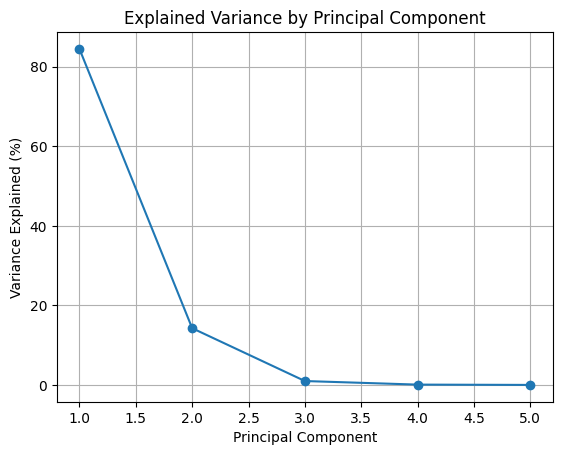

In [4]:
import matplotlib.pyplot as plt

# Only use first 6 principal components
plt.plot(range(1, 6), explained_variance[:5] * 100, marker='o')
plt.title("Explained Variance by Principal Component")
plt.xlabel("Principal Component")
plt.ylabel("Variance Explained (%)")
plt.grid(True)
plt.show()

## Principal Component Loadings Plot

This plot shows the **loadings** of the first three principal components (PCs) across different bond maturities. Each PC represents a common pattern of movement in the yield curve:

- **PC1 – Level**: Affects all maturities roughly equally, representing an overall shift in interest rates (up or down).
- **PC2 – Slope**: Opposite effects on short vs. long maturities, capturing steepening or flattening of the yield curve.
- **PC3 – Curvature**: Emphasizes the middle maturities, showing changes in the curve’s shape (hump or dip in the middle).

**X-axis** = Bond maturities (in years)  
**Y-axis** = Loading values (how much each maturity contributes to that PC)

This visualization helps interpret what each PC means in terms of yield curve dynamics and is key to understanding how PCA decomposes complex interest rate movements into simple, interpretable components.

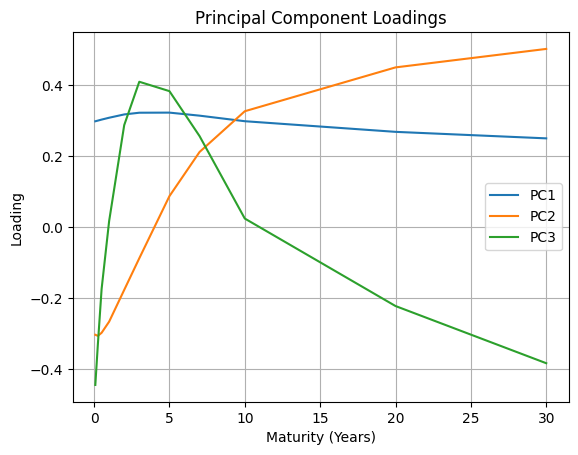

In [5]:
maturity_labels = df.columns
maturity_nums = [1/12, 0.25, 0.5, 1, 2, 3, 5, 7, 10, 20, 30]  # In years

for i in range(3):
    plt.plot(maturity_nums, components[i], label=f"PC{i+1}")

plt.legend()
plt.title("Principal Component Loadings")
plt.xlabel("Maturity (Years)")
plt.ylabel("Loading")
plt.grid(True)
plt.show()

## Plot PC Scores Over Time

This plot shows the **scores** for the first three principal components (PC1, PC2, and PC3) over time. Each score represents how much that specific principal component (Level, Slope, Curvature) contributed to the yield curve’s shape on a given day.

- **PC1 Score**: Represents the **level** of interest rates on that day. High scores indicate a general increase in rates.
- **PC2 Score**: Represents the **slope** of the yield curve. Positive values indicate a steeper curve, while negative values show a flattening.
- **PC3 Score**: Represents the **curvature** of the yield curve. Positive values indicate a U-shaped curve (higher at middle maturities), and negative values show a more inverted shape.

This plot helps us understand **how the yield curve changes** over time and how much each of the three dominant components (Level, Slope, Curvature) contributed to those changes.

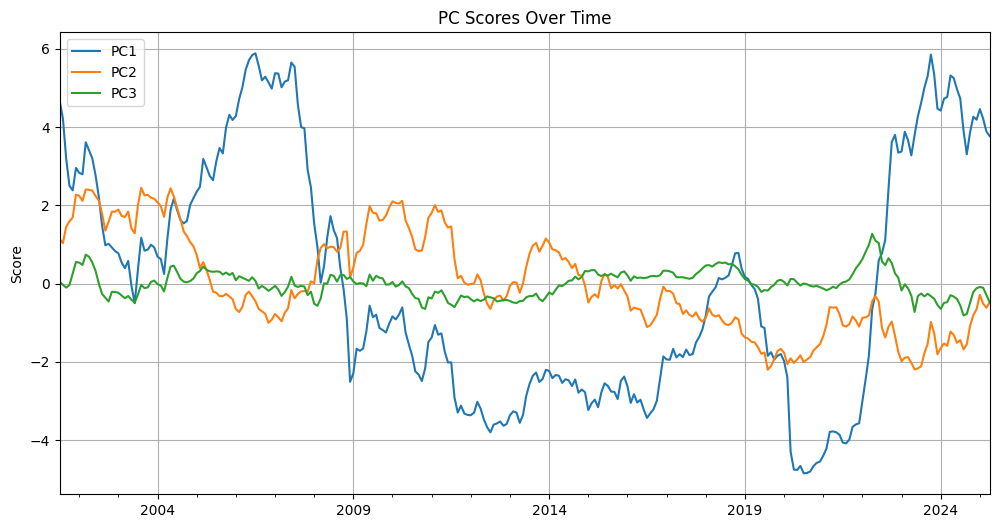

In [6]:
scores_df = pd.DataFrame(scores[:, :3], columns=['PC1', 'PC2', 'PC3'], index=df.index)

scores_df.plot(title="PC Scores Over Time", figsize=(12, 6))
plt.grid(True)
plt.ylabel("Score")
plt.show()

In [7]:
scores_df.head()

,PC1,PC2,PC3
2001-07-01,4.677029,1.139959,0.049393
2001-08-01,4.218833,1.037810,-0.029742
2001-09-01,3.199275,1.453342,-0.100695
2001-10-01,2.503571,1.593215,-0.035365
2001-11-01,2.383474,1.692698,0.254450


In [8]:
import pandas as pd

recession = (
    pd.read_csv(
        "USREC.csv",
        header=0,
        parse_dates=['observation_date'],
        index_col='observation_date').rename(columns={'USREC': 'Recession'}))

recession['Recession'] = pd.to_numeric(recession['Recession'], errors='coerce')

recession = recession.asfreq('MS').ffill()

scores_df.index.freq = 'MS'                 
scores_df['Recession'] = recession.reindex(scores_df.index).ffill()
scores_df

,PC1,PC2,PC3,Recession
2001-07-01,4.677029,1.139959,0.049393,1
2001-08-01,4.218833,1.037810,-0.029742,1
2001-09-01,3.199275,1.453342,-0.100695,1
2001-10-01,2.503571,1.593215,-0.035365,1
2001-11-01,2.383474,1.692698,0.254450,1
...,...,...,...,...
2024-12-01,4.190517,-0.650428,-0.115735,0
2025-01-01,4.461196,-0.285221,-0.085421,0
2025-02-01,4.218546,-0.507197,-0.102469,0
2025-03-01,3.890213,-0.615426,-0.289374,0


In [9]:
# Convert index to datetime
scores_df.index = pd.to_datetime(scores_df.index)
scores_df = scores_df.sort_index()

# Merge with price
merged_df = scores_df[['PC1', 'PC2', 'PC3']].join(spy_df['SPY'], how='inner')
merged_df.head()

,PC1,PC2,PC3,SPY
2001-08-01,4.218833,1.037810,-0.029742,122.11
2001-10-01,2.503571,1.593215,-0.035365,104.27
2001-11-01,2.383474,1.692698,0.254450,108.51
2002-02-01,2.796257,2.116819,0.479667,112.65
2002-03-01,3.614326,2.407873,0.741304,113.74


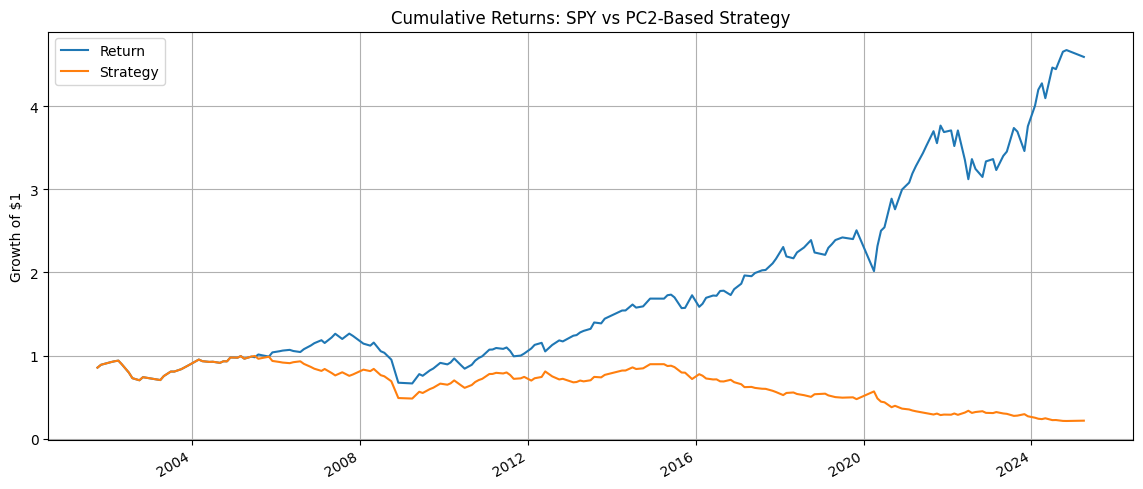

In [10]:
merged_df['Signal'] = merged_df['PC2'].apply(lambda x: 1 if x > 0 else -1)

# Calculate daily returns of SPY
merged_df['Return'] = merged_df[symbol].pct_change()

# Strategy return = signal * return
merged_df['Strategy'] = merged_df['Signal'].shift(1) * merged_df['Return']

(1 + merged_df[['Return', 'Strategy']]).cumprod().plot(figsize=(14, 6))
plt.title('Cumulative Returns: SPY vs PC2-Based Strategy')
plt.ylabel('Growth of $1')
plt.grid(True)
plt.show()

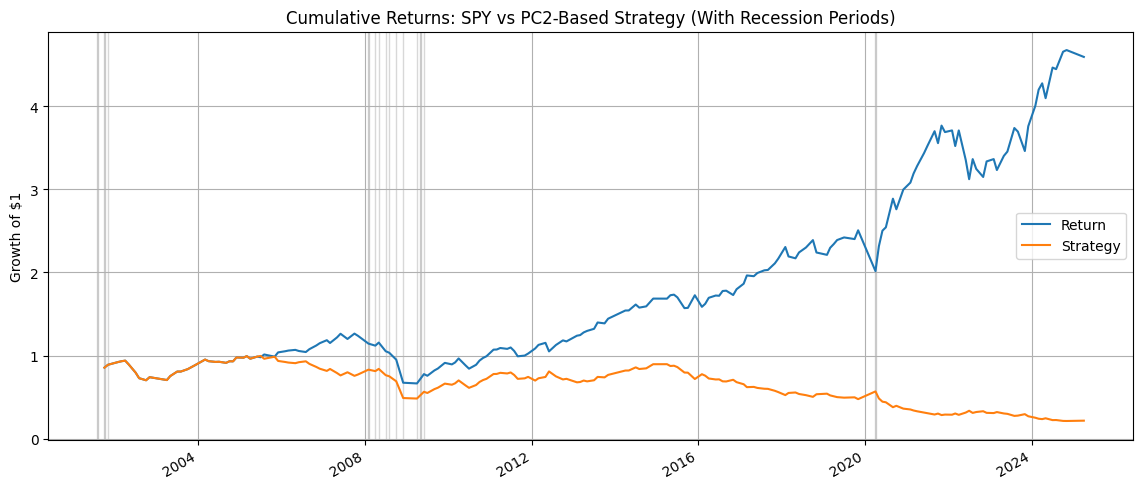

In [11]:
# Add NBER recession shading
from pandas_datareader.data import DataReader

recession_data = DataReader('USREC', 'fred', merged_df.index.min(), merged_df.index.max())
merged_df['Recession'] = recession_data

ax = (1 + merged_df[['Return', 'Strategy']]).cumprod().plot(figsize=(14, 6))
ax.set_title('Cumulative Returns: SPY vs PC2-Based Strategy (With Recession Periods)')
ax.set_ylabel('Growth of $1')
ax.grid(True)

# Shade recession periods
for date, is_recession in merged_df['Recession'].items():
    if is_recession:
        ax.axvspan(date, date + pd.Timedelta(days=1), color='gray', alpha=0.3)

plt.show()

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

X = scores_df[['PC1', 'PC2', 'PC3']]
y = scores_df['Recession']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

rf = RandomForestClassifier(class_weight='balanced', random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

xgb = XGBClassifier(scale_pos_weight= (y_train == 0).sum() / (y_train == 1).sum(), eval_metric='logloss')
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98        79
           1       0.83      0.71      0.77         7

    accuracy                           0.97        86
   macro avg       0.90      0.85      0.88        86
weighted avg       0.96      0.97      0.96        86

[[78  1]
 [ 2  5]]
